In [20]:
import sys

sys.path.append("../")

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [23]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [24]:
%config InlineBackend.figure_format = 'retina'

In [25]:
EXPERIMENT_NAME = "runs_multi"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [51]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_multi
Available domains: ['re2', 'clevr', 'logo']


# Tasks solved vs. LAPS iteration

In [88]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)

In [89]:
df_results

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
461,REGEX,DreamCoder,111,0,train,16,3.258656
462,REGEX,DreamCoder,111,1,train,32,6.517312
463,REGEX,DreamCoder,111,2,train,57,11.608961
465,REGEX,DreamCoder,111,3,train,77,15.682281
466,REGEX,DreamCoder,111,4,train,102,20.773931
...,...,...,...,...,...,...,...
251,CLEVR,LILO (+ Search),333,9,train,191,100.000000
238,CLEVR,LILO (+ Search),333,0,test,79,76.699029
242,CLEVR,LILO (+ Search),333,3,test,95,92.233010
246,CLEVR,LILO (+ Search),333,6,test,101,98.058252


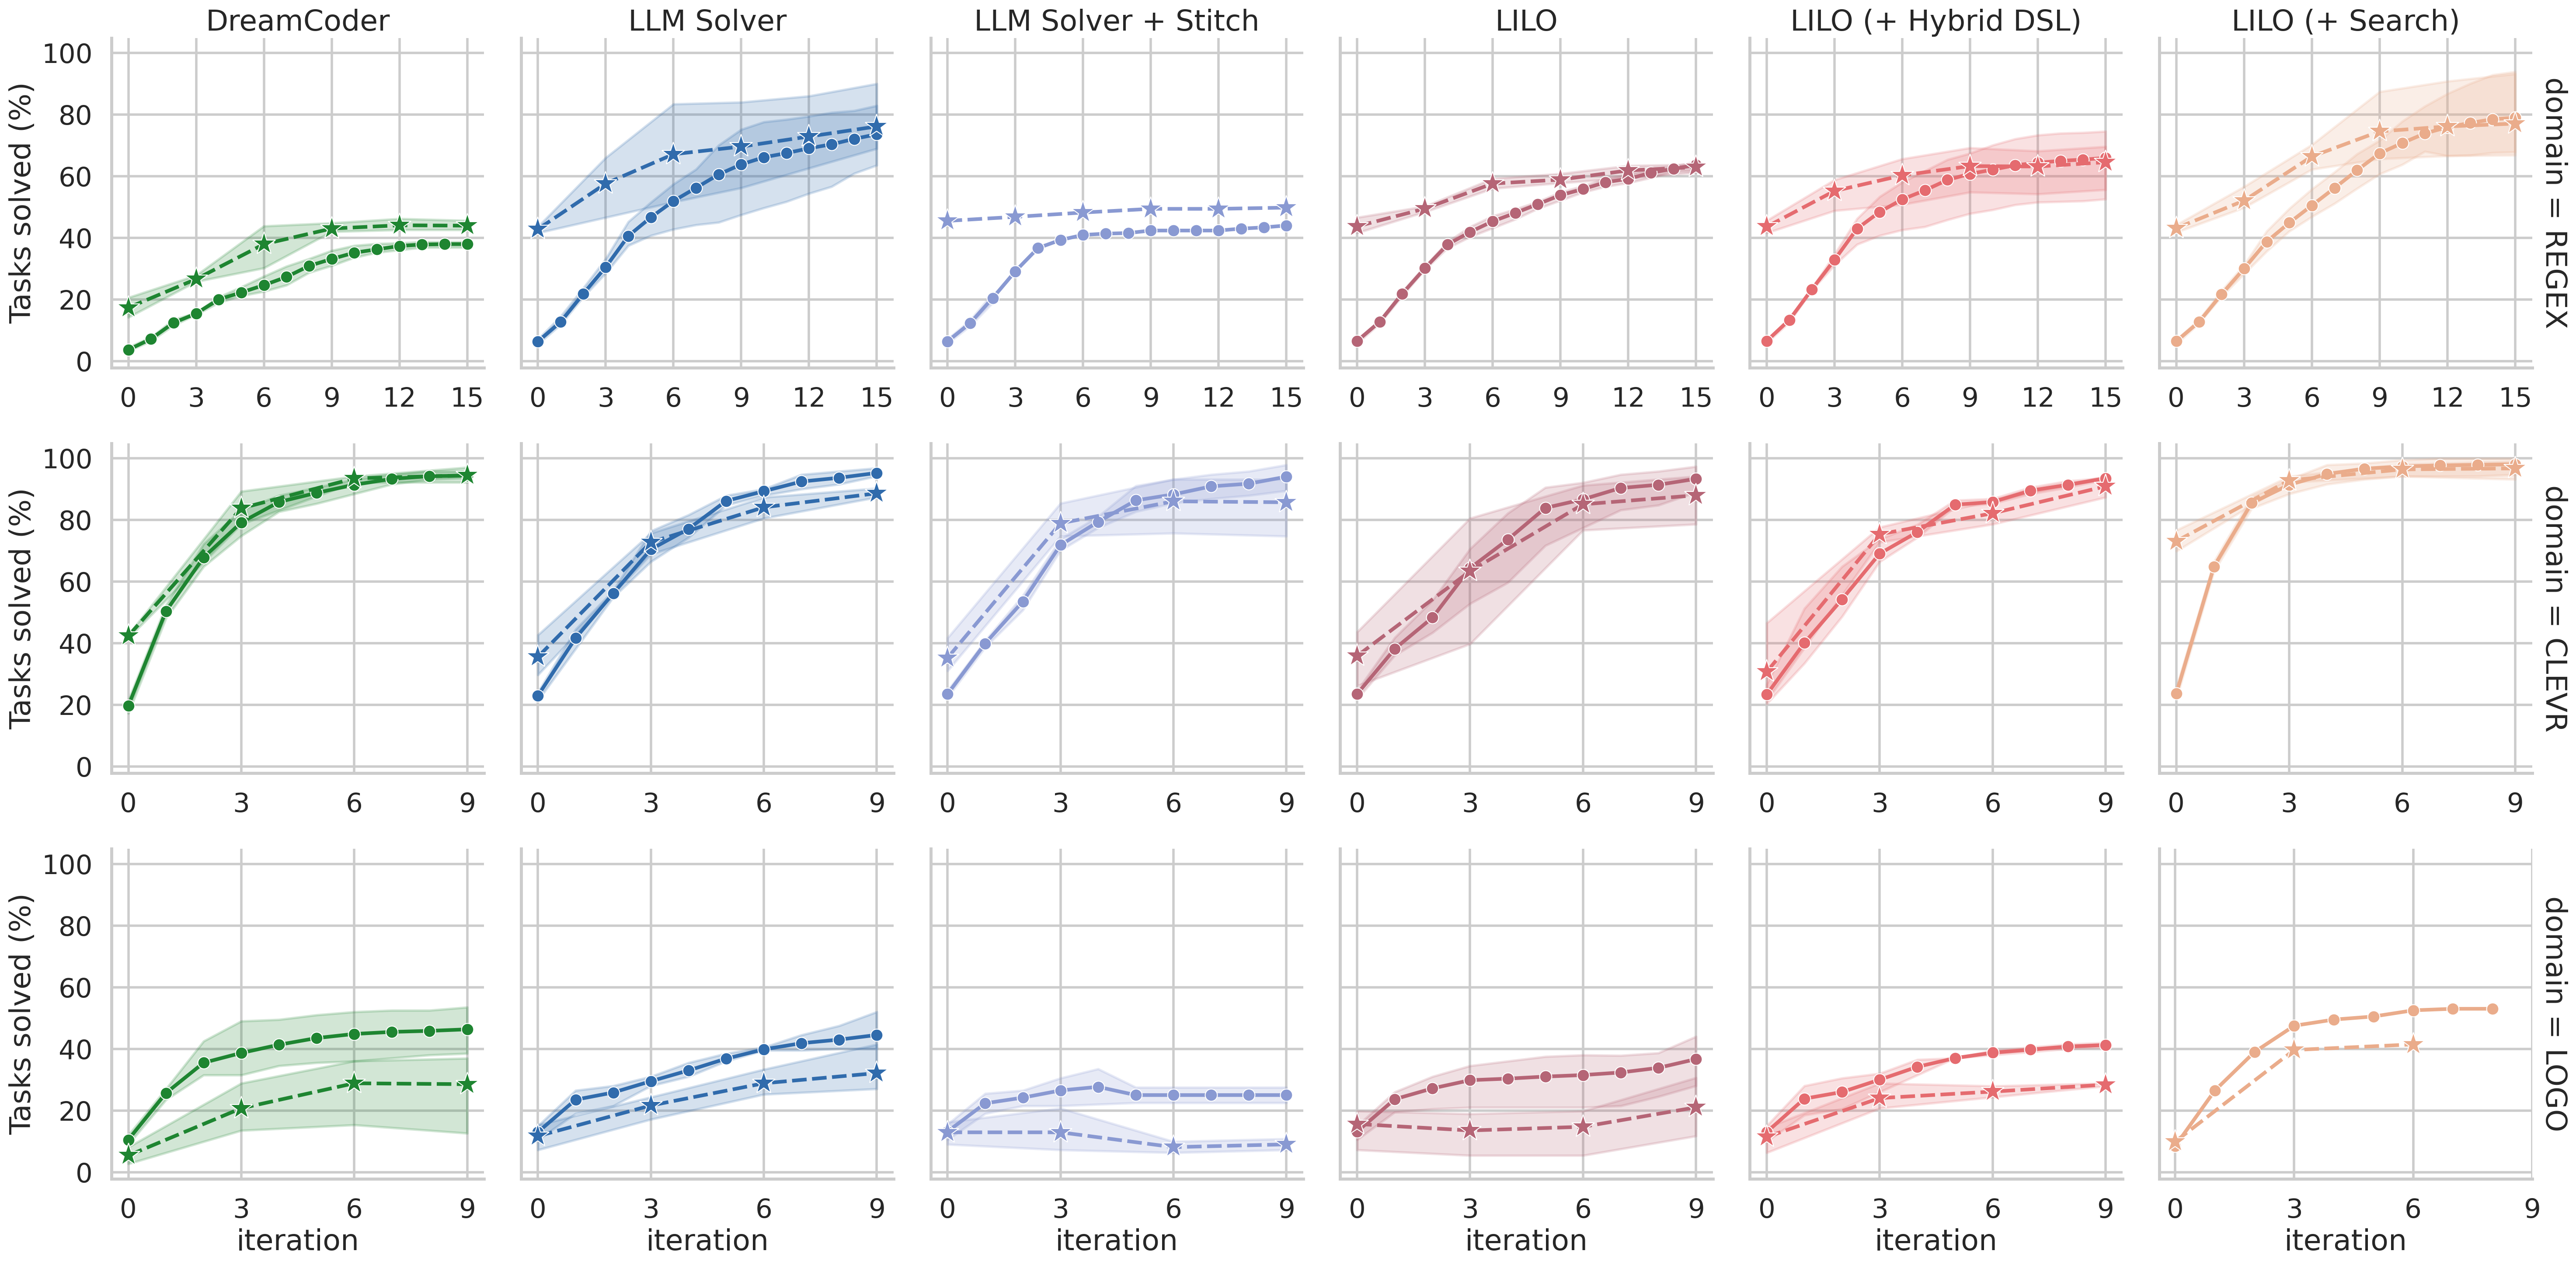

In [91]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        style="split",
        markers=[".", "*"],
        markersize=20,
        # errorbar="se",
        # col_order=["train", "test"],
        row_order = list(analyzer.DOMAIN_NAMES_CAMERA.values()),
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=False,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    for ax in g.axes[0]:
        ax.set_xticks(np.arange(0, 16, 3))
    for ax in g.axes[1]:
        ax.set_xticks(np.arange(0, 10, 3))
    for ax in g.axes[2]:
        ax.set_xticks(np.arange(0, 10, 3))
        
    # sns.move_legend(g, "lower center")
        
    plt.savefig(os.path.join(FIGURES_DIR, "main_results.pdf"), dpi=300, bbox_inches="tight")

In [14]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    # style="seed",
    markers=True,
    errorbar="sd", # se
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

ValueError: Could not interpret value `percent_solved` for parameter `y`

In [15]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    style="seed",
    markers=True,
    # errorbar="se",
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

# Main results table

In [93]:
df_results_test = df_results.query("split == 'test'")
grouped = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_iteration(group):
    final_iteration = group["iteration"].max().item()
    return group[group["iteration"] == final_iteration]

df_results_test = grouped.apply(_get_final_iteration).reset_index(drop=True)
df_results_test

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
0,CLEVR,DreamCoder,111,9,test,100,97.087379
1,CLEVR,DreamCoder,222,9,test,97,94.174757
2,CLEVR,DreamCoder,333,9,test,95,92.233010
3,CLEVR,LILO,111,9,test,81,78.640777
4,CLEVR,LILO,222,9,test,97,94.174757
5,CLEVR,LILO,333,9,test,94,91.262136
6,CLEVR,LILO (+ Hybrid DSL),111,9,test,94,91.262136
7,CLEVR,LILO (+ Hybrid DSL),222,9,test,90,87.378641
8,CLEVR,LILO (+ Hybrid DSL),333,9,test,97,94.174757
9,CLEVR,LILO (+ Search),111,9,test,96,93.203883


In [154]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

df_metrics_test = df_metrics_test.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=0)


# df_metrics_test

In [161]:
df_metrics_test

Tasks solved (%)                      
                                       mean        max        std
domain Model                                                     
REGEX  DreamCoder                 43.933333  45.600000   1.527525
       LILO                       62.933333  63.800000   1.501111
       LILO (+ Hybrid DSL)        64.533333  69.600000   7.759725
       LILO (+ Search)            77.066667  93.200000  14.144021
       LLM Solver                 76.133333  90.000000  12.035503
       LLM Solver + Stitch        46.900000  49.800000   4.101219
CLEVR  DreamCoder                 94.498382  97.087379   2.443312
       LILO                       88.025890  94.174757   8.257185
       LILO (+ Hybrid DSL)        90.938511  94.174757   3.409597
       LILO (+ Search)            96.763754  99.029126   3.120923
       LLM Solver                 88.673139  90.291262   1.483034
       LLM Solver + Stitch        85.760518  93.203883   9.724906
LOGO   DreamCoder                 28.528529  36.936937  13.790946
       LILO                       21.021021  30.630631   9.463034
       LILO (+ Hybrid DSL)        28.528529  28.828829   0.520135
       LILO (+ Search)            41.441441  41.441441        NaN
       LLM Solver                 32.132132  41.441441   8.074672
       LLM Solver + Stitch        12.912913  20.720721   6.997706

In [196]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain").reorder_levels(order=[0, 2, 1], axis="columns")

multiindex = df_metrics_test_final.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["max", "mean", "std"], level=2)[0]

df_metrics_test_final = df_metrics_test_final.reindex(columns=multiindex)
df_metrics_test_final.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("main_results_table.tex")

df_metrics_test_final

Tasks solved (%)                                           \
                               REGEX                CLEVR                LOGO   
                                 max   mean    std    max   mean   std    max   
DreamCoder                      45.6  43.93   1.53  97.09  94.50  2.44  36.94   
LLM Solver                      90.0  76.13  12.04  90.29  88.67  1.48  41.44   
LLM Solver + Stitch             49.8  46.90   4.10  93.20  85.76  9.72  20.72   
LILO                            63.8  62.93   1.50  94.17  88.03  8.26  30.63   
LILO (+ Hybrid DSL)             69.6  64.53   7.76  94.17  90.94  3.41  28.83   
LILO (+ Search)                 93.2  77.07  14.14  99.03  96.76  3.12  41.44   

                                   
                                   
                      mean    std  
DreamCoder           28.53  13.79  
LLM Solver           32.13   8.07  
LLM Solver + Stitch  12.91   7.00  
LILO                 21.02   9.46  
LILO (+ Hybrid DSL)  28.53   0.52  
LILO (+ Search)      41.44    NaN

# Runtime metrics

In [ ]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

In [ ]:
df_infer_programs = df_runtime.query("model_fn == 'infer_programs_for_tasks'").query("model_type != 'grammar'")
df_infer_programs

In [ ]:
analyzer.format_dataframe_camera(df_infer_programs)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="bar",
    col="domain",
    row="task_split",
    sharex=False, 
    y="model_type",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="domain",
    row="model_type",
    sharex=False, 
    sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="model_type",
    row="domain",
    sharex=True,
    # sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)